## Imports

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/bij/Projects/fdtd/')
import fdtd
import fdtd.backend as bd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Set Grid

In [24]:
fdtd.set_backend("torch")
WAVELENGTH = 1550e-9
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light

grid = fdtd.Grid(
    #(8.5e-6, 8.5e-6, 8.5e-6), 
    #(1.5e-5, 1.5e-5, 1.5e-5),
    #(3.5e-6, 3.5e-6, 3.5e-6),
    #(1.5e-6, 1.5e-6, 1.5e-6),
    #(3.5e-6, 1.0e-6, 1.0e-6),
    #(3.0e-6, 0.75e-6, 0.75e-6),
    #(3.0e-5, 0.5e-6, 0.5e-6),
    #(3.0e-4, 0.75e-5, 0.75e-5),
    #(0.1e-5, 0.75e-6, 0.75e-6),
    #(10.0e-5, 0.75e-6, 0.75e-6),
    #grid_spacing=0.1 * WAVELENGTH,
    #grid_spacing=0.05 * WAVELENGTH,
    (1.0e-5, 0.75e-6, 0.75e-6),
    grid_spacing=0.01 * WAVELENGTH,
    permittivity=1.0,
    permeability=1.0,
)
print(grid.shape)

# grid[0, :, :] = fdtd.PeriodicBoundary(name="xbounds")
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")

# grid[:, 0, :] = fdtd.PeriodicBoundary(name="ybounds")
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

#grid[:, :, 0] = fdtd.PeriodicBoundary(name="zbounds")
grid[:, :, 0:10] = fdtd.PML(name="pml_zlow")
grid[:, :, -10:] = fdtd.PML(name="pml_zhigh")


(645, 48, 48)


In [25]:
grid._handle_distance(WAVELENGTH/4.0)

25

## Objects, Sources, and Detectors

In [26]:
grid[20, :, :] = fdtd.PlaneSource(
    period=WAVELENGTH / SPEED_LIGHT, name="planesource_0", polarization='z'
)
grid[45, :, :] = fdtd.PlaneSource(
    period=WAVELENGTH / SPEED_LIGHT, name="planesource_1", polarization='y'
)
grid[:, grid.shape[1]//2, grid.shape[2]//2] = fdtd.LineDetector(name="detector")

## Functions

In [112]:
def plot_EH_3d_vectors(E_vectors, H_vectors=None, scale=1.0, step=None, rotation_angle=None):
    clear_output(wait=True)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_proj_type('ortho')  # FOV = 0 deg
    #ax.set_proj_type('persp')  # FOV = 90 deg
    #ax.set_proj_type('persp', focal_length=0.2)  # FOV = 157.4 deg
    #ax.set_facecolor((0, 0, 0))
    #ax.w_xaxis.set_pane_color((0,0,0.0))
    #ax.w_yaxis.set_pane_color((0,0,0.0))
    #ax.w_zaxis.set_pane_color((0,0,0.0))
    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    def normalize_and_plot(vectors, color):
        # Normalize vectors
        #normalized_vectors = vectors / np.max([np.linalg.norm(v) for v in vectors])
        normalized_vectors = vectors 

        # Extract x, y, z components of each normalized vector
        x = [v[0] for v in normalized_vectors]
        y = [v[1] for v in normalized_vectors]
        z = [v[2] for v in normalized_vectors]

        # Plot the vectors
        if(step):
            colors = np.zeros((len(x), 4))
            colors[:, 0] = color == 'red'
            colors[:, 2] = color == 'blue'
            colors[:, 3] = np.clip(np.arange(len(x))/step, 0, 1)
        else:
            colors = color
        ax.quiver(np.arange(len(x))/len(x), 0, 0, x, y, z, length=scale, arrow_length_ratio=0.0, colors=colors)
        #ax.plot(x, y, z)

    normalize_and_plot(E_vectors, color='red')
    if(H_vectors is not None):
        normalize_and_plot(H_vectors, color='blue')
        
    # Set limits for the axes
    #ax.set_xlim([-scale, scale])
    ax.set_xlim([0, scale])
    ax.set_ylim([-scale, scale])
    ax.set_zlim([-scale, scale])

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Normalized 3D Vector Plot')
    
    if (rotation_angle):
        ax.view_init(elev=rotation_angle[0], azim=rotation_angle[1])


    plt.show()


boundaries

In [6]:
grid.reset()
grid.run(80, progress_bar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [05:17<00:00,  3.97s/it]


sources

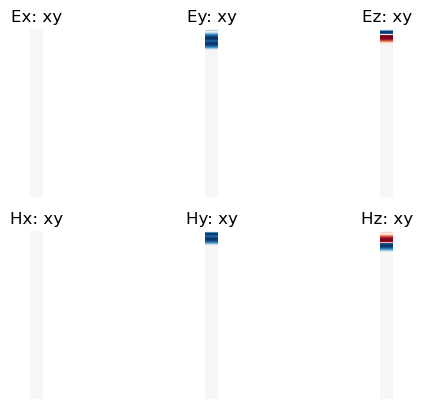

In [113]:
fig, axes = plt.subplots(2, 3, squeeze=False)
titles = ["Ex: xy", "Ey: xy", "Ez: xy", "Hx: xy", "Hy: xy", "Hz: xy"]

fields = bd.stack(
    [
        grid.E[:, :, 0, 0],
        grid.E[:, :, 0, 1],
        grid.E[:, :, 0, 2],
        grid.H[:, :, 0, 0],
        grid.H[:, :, 0, 1],
        grid.H[:, :, 0, 2],
    ]
)

m = max(abs(fields.min().item()), abs(fields.max().item()))

for ax, field, title in zip(axes.ravel(), fields, titles):
    ax.set_axis_off()
    ax.set_title(title)
    ax.imshow(bd.numpy(field), vmin=-m, vmax=m, cmap="RdBu")

plt.show()

In [111]:
Es = bd.stack(grid.detectors[0].E, axis=0)
Hs = bd.stack(grid.detectors[0].H, axis=0)
for ang in range(0, 360):
    #plot_EH_3d_vectors(Es[-1, ::2, :], Hs[-1, ::2, :], step=40, rotation_angle=(30, ang))
    plot_EH_3d_vectors(Es[-1, ::2, :], step=40, rotation_angle=(30, ang))

KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

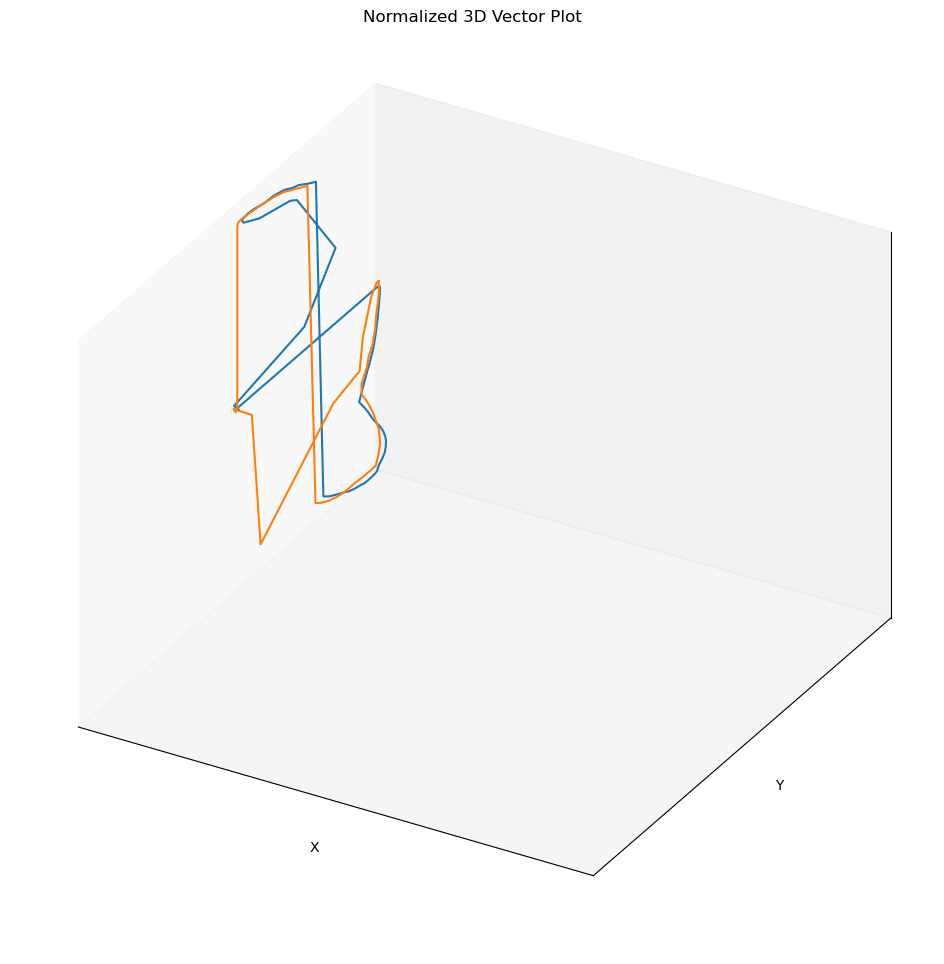

In [106]:
#plot_EH_3d_vectors(Es[-1, 0:100, :], Hs[-1, 0:100, :])
plot_EH_3d_vectors(Es[-1, 0:100, :], Hs[-1, 0:100, :])

## Run simulation

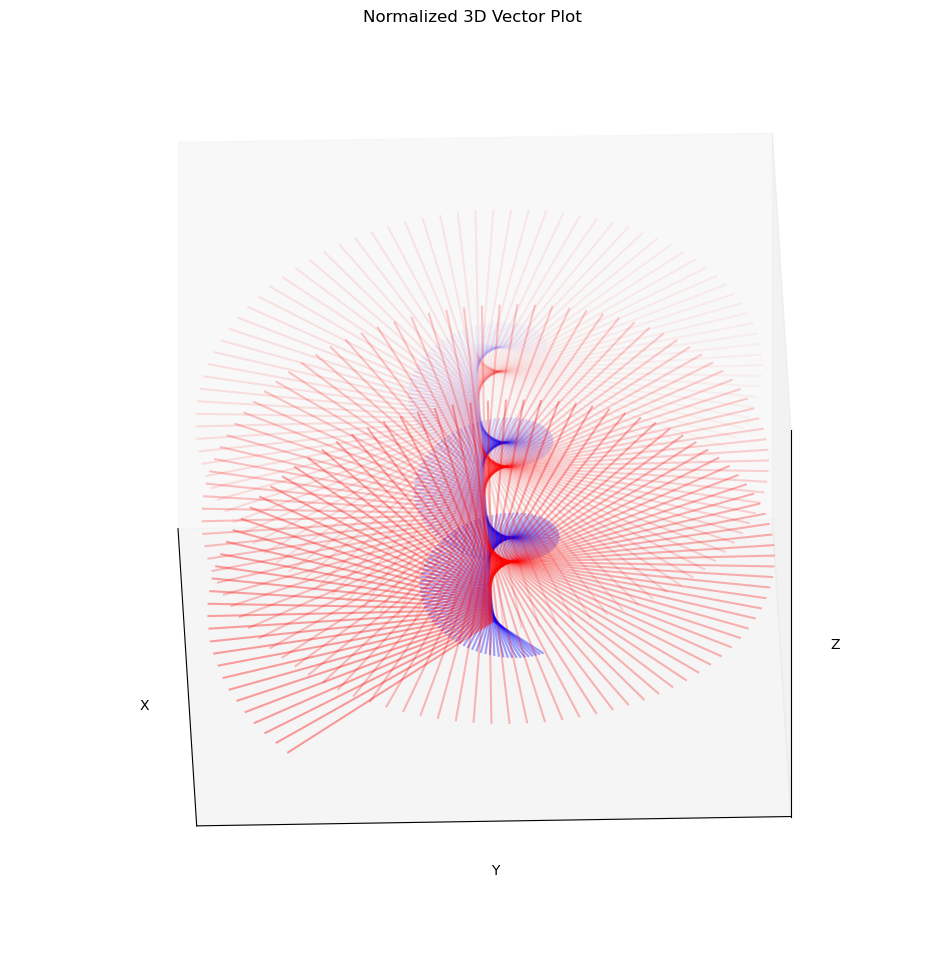

In [133]:
grid.reset()
max_steps = 800
wiggle = 30
for step in range(max_steps):
    print('On step: {0}/{1}'.format(step+1, max_steps), end='\r')
    grid.run(1, progress_bar=False)
    Es = bd.stack(grid.detectors[0].E, axis=0)
    Hs = bd.stack(grid.detectors[0].H, axis=0)
    plot_EH_3d_vectors(Es[-1, 40:340, :], Hs[-1, 40:340, :]/4, step=step, rotation_angle=(30, float(4*360*step)/max_steps))
    #plot_EH_3d_vectors(Es[-1, 40:340, :], Hs[-1, 40:340, :], step=None, rotation_angle=(30, float(4*360*step)/max_steps))
    #plot_EH_3d_vectors(Es[-1, 40:340, :], step=None, rotation_angle=(30, float(4*360*step)/max_steps))
    #plot_EH_3d_vectors(Es[-1, 40:340, :], step=None, rotation_angle=(0, 270 + (step % 10 - 5)/10 * wiggle ))

## Visualization

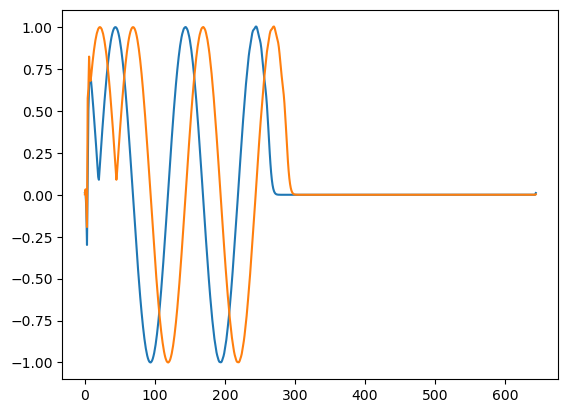

In [120]:
plt.plot(Hs[-1, :, 1])
plt.plot(Es[-1, :, 1])

Emax:  tensor(1.1474)
Hmax:  tensor(1.3248)


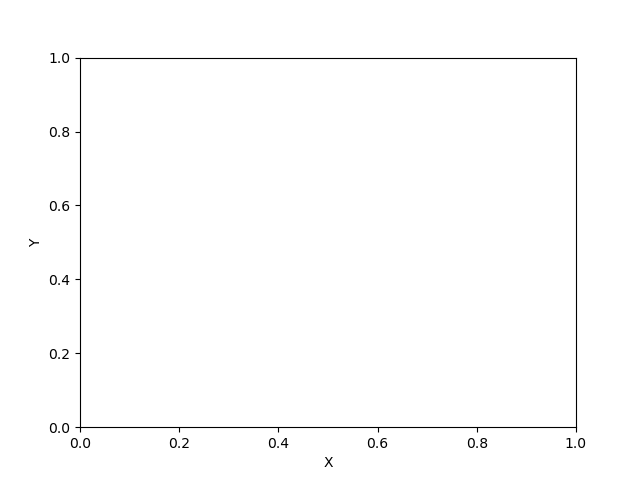